In [128]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import brentq

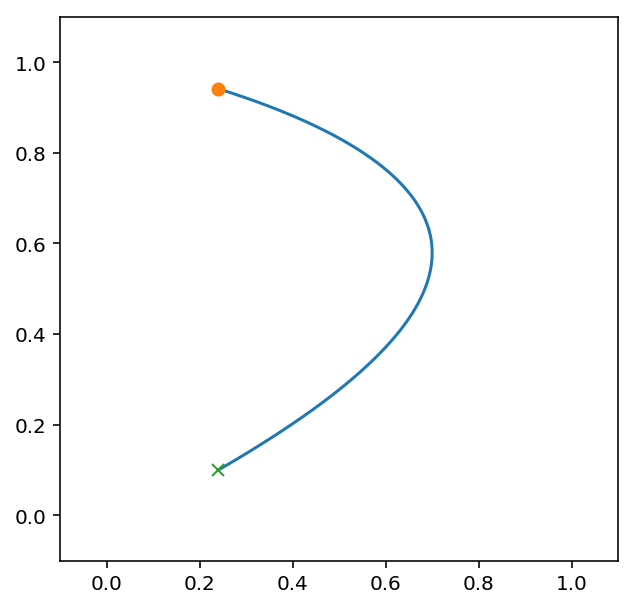

In [142]:
def f(l):
    ''' Defining the convex surface as a function of a scalar '''
#     return np.asarray((np.tanh(l), np.cos(l)))
    return np.asarray((np.cos(2 * l - 1) - 0.3, np.sin(1 - l) + 0.1))

# High-density mesh of points
SAMPLES_LAMBDA = np.linspace(0, 1, 1000)
SAMPLES = f(SAMPLES_LAMBDA)


def plot_line(size=5):
    ''' Plot the surface on which we're "printing" '''
    plt.figure(figsize=(size, size))
    x_samples, y_samples = SAMPLES
    plt.plot(x_samples, y_samples)
    plt.plot(x_samples[0], y_samples[0], 'o')
    plt.plot(x_samples[-1], y_samples[-1], 'x')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)

plot_line()
plt.show();

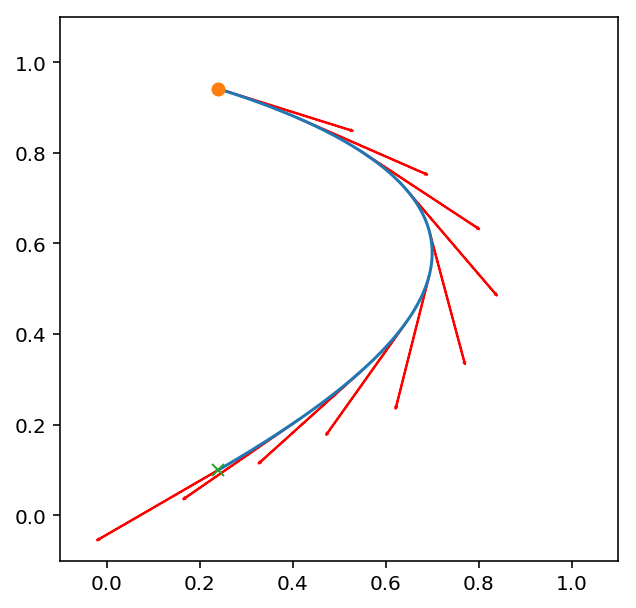

In [130]:
def _compute_tangent(r0, r1):
    ''' Compute the tangent given two locations on it. Returns None if the two locations are
        the same.
    '''
    if np.all(r0 == r1):
        return None
    tangent = (r1 - r0)
    tangent /= np.linalg.norm(tangent)
    return tangent

    
def tangent(l, delta=0.001):
    ''' Compute the tangent direction at the given point '''
    r0 = f(l)
    rm1 = f(np.maximum(l - delta, 0))
    r1 = f(np.minimum(l + delta, 1))
    
    tangents_to_average = [tangent for tangent in 
                           (_compute_tangent(r0, r1), _compute_tangent(rm1, r0)) 
                           if tangent is not None]
    return np.mean(np.asarray(tangents_to_average), axis=0)
    

def plot_tangent(l):
    direction = tangent(l)
    x, y = f(l)
    length = 0.3
    plt.arrow(x, y, length * direction[0], length * direction[1], ec='r')

    
def plot_tangents():
    for l in np.linspace(0, 1, 10):
        plot_tangent(l)

plot_line()
plot_tangents()

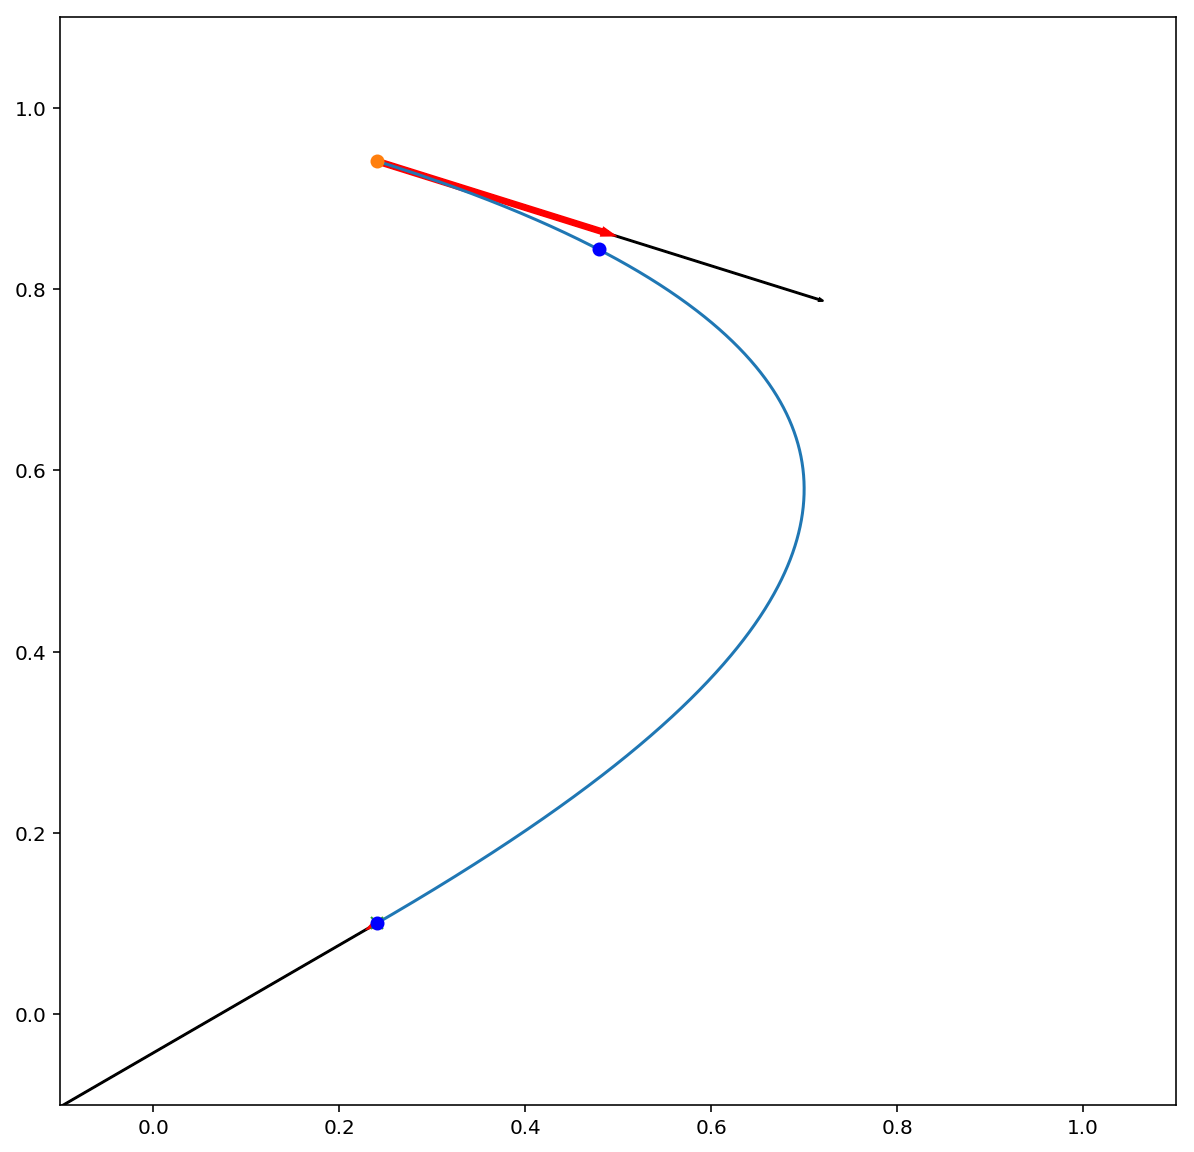

In [196]:
MAX_D = 0.02
LENGTH = 0.5


def distance_and_lambda(l, d):
    ''' Assume that there is a tangent to the curve at l, or equivalently r0 in cartesian co-ordinates.
        The tangent is directed in terms of +ve lambda.
        
        As a distance d along this tangent (at point r1), create a perpendicular line - this will intersect 
        with the main curve at least once. Find the "nearest" intersection, as defined by the closest in 
        terms of lambda, and return the distance between this intersection and r1.
        
        Also return the lambda of the intersection.
    '''
    if d == 0.:
        # By definition, this case is trivial
        return 0, l
    
    tangent_dir = tangent(l)
    
    # r1 is the point at which we create the perpendicular.
    # For every point in the surface samples, compute whether they are 'left' or 'right' of this division.
    r1 = f(l) + d * tangent_dir

    if d > 0:
        # We are looking in the direction of increasing lambda
        i_l = np.searchsorted(SAMPLES_LAMBDA, l)
        samples = SAMPLES.T[i_l:,]
        samples_lambda = SAMPLES_LAMBDA[i_l:]
        
        indicator = np.sign((samples - r1).dot(tangent_dir))

        # -ve values indicate being on the r0 side of the division. Find the first
        # value where this is no longer true, and take this as the intersection point.
        changes = np.argwhere(indicator == 1)
        if len(changes) > 0:
            i_intersection = changes[0][0]
        else:
            # All points are valid up to the last value of lambda
            i_intersection = -1
        return np.linalg.norm(r1 - samples[i_intersection]), samples_lambda[i_intersection]
        
    elif d < 0:
        # We are looking in the direction of decreasing lambda
        i_l = np.searchsorted(SAMPLES_LAMBDA, l, side='right')
        samples = SAMPLES.T[:i_l,]
        samples_lambda = SAMPLES_LAMBDA[:i_l]

        indicator = np.sign((samples - r1).dot(tangent_dir))

        # +ve values indicate being to the r0 side of the division. Find the first value
        # where this is no longer true (in terms of *decreasing* lambda, so the last element
        # of the array)
        changes = np.argwhere(indicator == -1)
        if len(changes) > 0:
            i_intersection = changes[-1][0]
        else:
            # All points are valid up to the first value of lambda
            i_intersection = 0
        return np.linalg.norm(r1 - samples[i_intersection]), samples_lambda[i_intersection]
        

def usable_print_head_length(l, max_d):
    ''' Return the usable length of print head, assuming that it starts tangential to and touching
        the curve at l. Also return lambda of the finish point.
    '''
    # Find the length d of the print head that is within MAX_D of the surface.
    target_func = lambda d: distance_and_lambda(l, d)[0] - max_d

    def _constrain_usable_length(length, lam):
        ''' We shouldn't return a usable print head length that extends beyond the end of the curve '''
        if lam < 1:
            return (length, lam)
        start = f(l)
        direction = tangent(l)
        end = f(1)
        max_length = np.linalg.norm((end - start).dot(direction))
        return np.minimum(length, max_length), lam
        
    # Boring case - we can use all of the print head!
    max_target = target_func(LENGTH)
    if max_target <= 0:
        return _constrain_usable_length(LENGTH, 1)
    
    # Otherwise find the intersection
    d = brentq(target_func, 0, LENGTH)
    return _constrain_usable_length(d, distance_and_lambda(l, d)[1])


def compute_and_plot_head(lambda_start):
    ''' Plot the print-head starting at the given lambda, and indicate which portion of it is
        within printing distance.
    '''
    r0 = f(lambda_start)
    direction = tangent(lambda_start)

    usable_length, lambda_finish = usable_print_head_length(lambda_start, MAX_D)
    r_finish = f(lambda_finish)
    
    # Plot the full length of the print head
    plt.arrow(r0[0], r0[1], LENGTH * direction[0], LENGTH * direction[1], ec='k', lw=1)
    # Plot the active length of the print head
    plt.arrow(r0[0], r0[1], usable_length * direction[0], usable_length * direction[1], ec='r', lw=3)
    
    # Plot the location to which we have printed
    plt.plot(r_finish[0], r_finish[1], 'bo')
    
    # Return where we finished
    return lambda_finish
    
    
plot_line(size=10)
compute_and_plot_head(0);
compute_and_plot_head(0.998998998999);

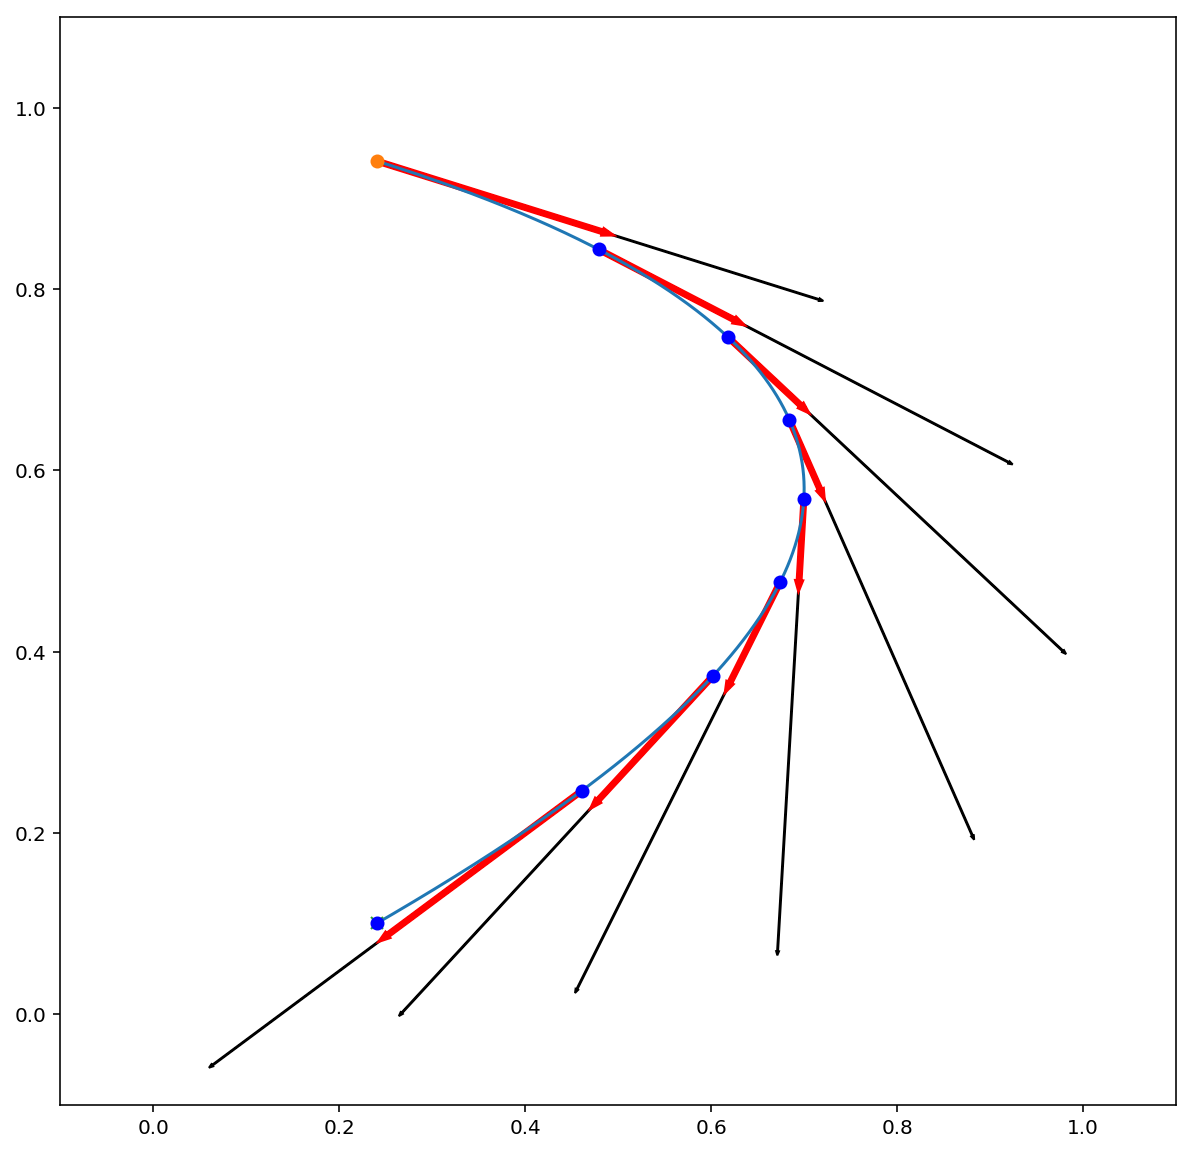

In [197]:
def plot_all_heads():
    ''' Using a naive construction, plot all print heads required to print on all the curve '''
    l = 0
    while l < 1:
        l = compute_and_plot_head(l)

plot_line(size=10)
plot_all_heads()
plt.show()

### TODO

1. Add minimum separation of the print head from the surface

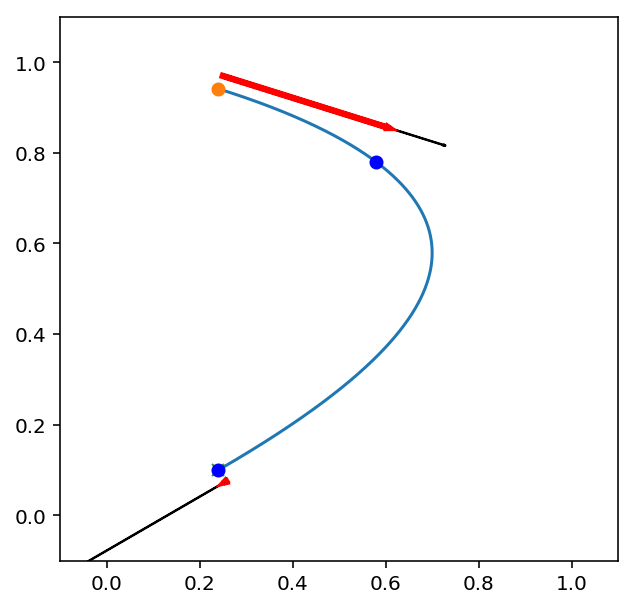

In [198]:
# Twiddle the min and max
MIN_D = 0.03
MAX_D = 0.08


def _ccw_90(vec):
    ''' Rotate the given vector by 90 degrees CCW '''
    return np.asarray((-vec[1], vec[0]))


def compute_and_plot_head_with_min(lambda_start):
    ''' Plot the print-head starting at the given lambda, and indicate which portion of it is
        within printing distance.
    '''
    r0 = f(lambda_start)
    direction = tangent(lambda_start)

    # TODO In general this example doesn't have enough information to define the normal, so we cheat
    # a bit for now
    normal = _ccw_90(direction)
    
    # The print head is at least MIN_D from the surface
    r0 += normal * MIN_D

    # Note that, if we have a minimum separation, this effectively reduces our maximum distance.
    usable_length, lambda_finish = usable_print_head_length(lambda_start, MAX_D - MIN_D)
    r_finish = f(lambda_finish)
    
    # Plot the full length of the print head
    plt.arrow(r0[0], r0[1], LENGTH * direction[0], LENGTH * direction[1], ec='k', lw=1)
    # Plot the active length of the print head
    plt.arrow(r0[0], r0[1], usable_length * direction[0], usable_length * direction[1], ec='r', lw=3)
    
    # Plot the location to which we have printed
    plt.plot(r_finish[0], r_finish[1], 'bo')
    
    # Return where we finished
    return lambda_finish
    
    
plot_line()
compute_and_plot_head_with_min(0);
compute_and_plot_head_with_min(0.998998998999);

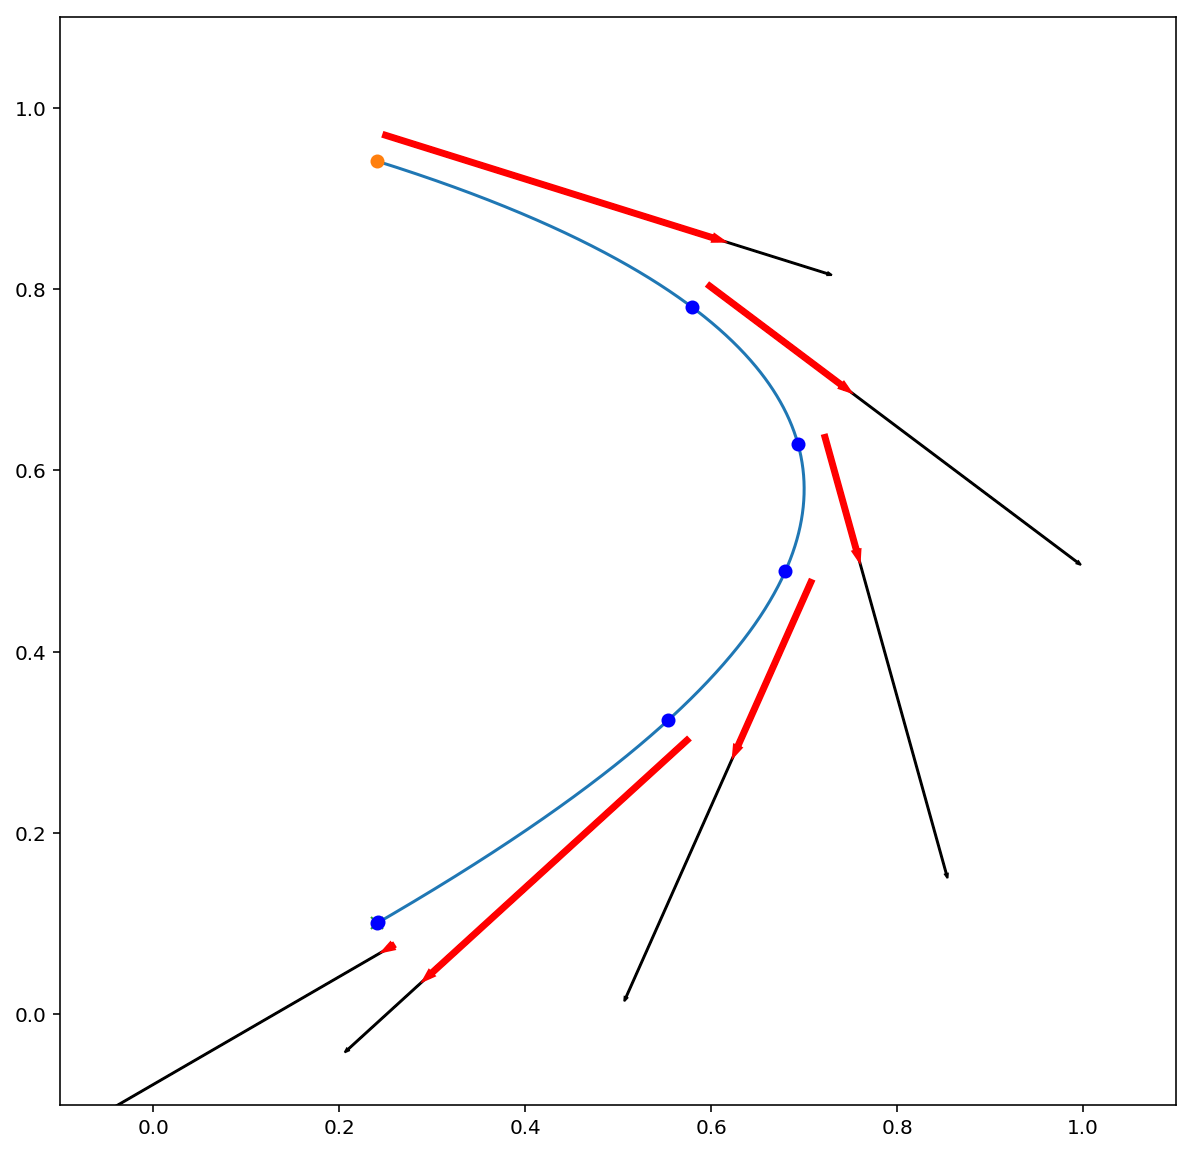

In [199]:
def plot_all_heads():
    ''' Using a naive construction, plot all print heads required to print on all the curve '''
    l = 0
    while l < 1:
        l = compute_and_plot_head_with_min(l)

plot_line(size=10)
plot_all_heads()
plt.show()